# Lightkurve tutorial

lightkurve is a python tool originally designed for use for the Kepler mission, that has been extended for the TESS mission. This package allows you to easily search, download, plot, manipulate, and interact with TESS data. In this notebook we will go through several examples of the basic usage of lightkurve. For more information and more complex examples, you can look at the full set of [tutorials](https://lightkurve.github.io/lightkurve/tutorials/index.html) provided by lightkurve. 

In [1]:
%matplotlib inline

In [2]:
import lightkurve as lk

/Users/nthom/opt/anaconda3/envs/py3/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/nthom/.lightkurve/cache. Please move all the files in the legacy directory /Users/nthom/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


For this tutorial, we will walk through the steps to search for and download data for the star AU Mic. This star has [at least 3](https://exoplanetarchive.ipac.caltech.edu/overview/AU%20Mic%20b#planet_AU-Mic-b_collapsible) transiting planets. It also happens to be extremely active, with frequent flares seen in white light data.

<div>
<img src="FlaresOfFury.jpeg" width="500"/>
<figcaption> NASA-JPL/Caltech </figcaption>
</div>

# 1 - Search and Download Data

TESS has 3 main data types. 
- Full Frame Images (FFIs): The full sector images, with a cadence of 30-min (years 1 & 2), 10-min (years 3 & 4), or 200-sec (years 5+).
- Target Pixel Files (TPFs): Postage stamp cut outs from the FFIs, focused on a selected target of interest. Each stamp has a cadence of 2-min or 20-sec.
- Light Curve Files (LCFs): The time series data produced for each 2-min or 20-sec TPF object.

All of the data is stored by MAST, but the files can be accessed via lightkurve. The first thing we will want to do for a new target is to check what data products are available for our target of interest. There is a different lightkurve command depending on what data product you are interested in. We will demonstrate all of these below. 

## 1.1 TESSCut
First, let's start with the FFIs. A single FFI is a really large data file and contains an image that covers 24x24 degrees of the sky. This is way more information than we need. TESS provides several tools to cutout smaller sections of data around your target, allowing you to get the data faster and with less memory resources. Lightkurve allows you to access one of the tools ([TESScut](https://mast.stsci.edu/tesscut/docs/getting_started.html)) directly.  



In [3]:
tcut_search_result = lk.search_tesscut('AU Mic') # This will search for full frame images
tcut_search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TESScut,1426,AU Mic,0.0
1,TESS Sector 27,2020,TESScut,475,AU Mic,0.0
2,TESS Sector 95,2025,TESScut,158,AU Mic,0.0


As you can see, the search returns a table containing information about the data available. In particulare, the 'author' column provides the source of the data (the pipeline that produced the data product) - in this case, TESSCut, which is the backend that cuts the data out of the FFI. The 'exptime' column provides the exposure time. Let's download the most recent available data (Sector 95 as of when this tutorial was written) and see how it looks. 

<Axes: title={'center': 'Target ID: AU Mic, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

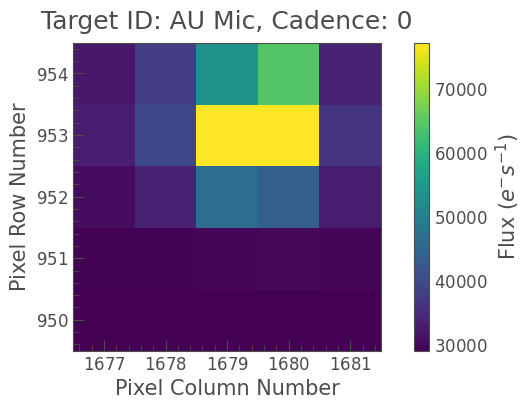

In [5]:
tcut = tcut_search_result[2].download()
tcut.plot()

Woah, that is too zoomed in! By default, lightkurve 'cuts' 5x5 pixels out of the Full Frame Image. However, that doesn't capture all of the star's flux in this case.  Let's try this again, but specify a larger cutout region. 

<Axes: title={'center': 'Target ID: AU Mic, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

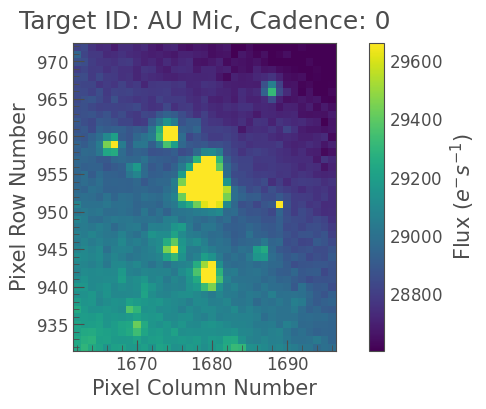

In [6]:
tcut = tcut_search_result[2].download(cutout_size=(41,35)) #cutout_size specifies the number of pixels in (row, col)
tcut.plot()

That's better! Now we can see the bright star in the middle, as well as several surrounding stars. While all of the stars look like distinct points in this image, TESS actually has a relatively large pixel scale (21 arcseconds/pixel), which means often there are multiple stars that are observed in the same pixel. We can use the [interact_sky()](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.KeplerTargetPixelFile.interact_sky.html) tool to help see what other targets are in the same field of view. These targets come from the [Gaia](https://www.esa.int/Science_Exploration/Space_Science/Gaia) catalog. You can hover your mouse over the red points to get details on each source. 

In [7]:
tcut[500:].interact_sky() # you made need to add "notebook_url='localhostXXXX' depending on your jupyter environment

/Users/nthom/opt/anaconda3/envs/py3/lib/python3.9/site-packages/lightkurve/interact.py:559: LightkurveWarning: interact_sky() - cannot obtain nearby TICs. Skip it. The error: not enough values to unpack (expected 3, got 2)
  warnings.warn(
/Users/nthom/opt/anaconda3/envs/py3/lib/python3.9/site-packages/lightkurve/interact.py:644: LightkurveWarning: Proper motion correction cannot be applied to the target, as none is available. Thus the target (the cross) might be noticeably away from its actual position, if it has large proper motion.
  warnings.warn(("Proper motion correction cannot be applied to the target, as none is available. "


If you noticed in the above call, the tcut object has a slice behind it \[500:]. This is because the interact_sky function will display the first image in the series. In this case, the first image is saturated by scattered light from the Earth. You can try removing that slice to see what it looks like. So how can we visually see what frames are strongly affected by scattered light? One way is by using the [interact](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.KeplerTargetPixelFile.interact.html) tool provided by lightkurve. 

This command will open a widget which allows you to slide over all of the time steps. You can clearly see that the image is saturated at the start, as well as the end of each orbit. On the left of the widget there is a plot showing a lightcurve for the data. This is the sum of the counts for all of the pixels in the aperture. The aperture being used is displayed on the right. You can modify the default pixels by clicking on the desired pixels (you can shift-click to select multiple pixels). As you add pixels, you can see that the lightcurve on the left is updated accordingly. When you have a lightcurve you are happy with, you can clicke the 'Save Lightcurve' button to save the data as a fits file. 



In [8]:
tcut.interact()

## 1.2 Pre-made TPFs

You can create your own lightcurve from cutouts. Alternatively there are several pipelines that have taken the FFIs, applied various detrending methods, and created an aperture for the target star. You can search for these premade products using the search_targetpixelfile() function. For these, you cannot specify a cutout size. For this star, there are two different authors, SPOC and TESS-SPOC. [SPOC](https://heasarc.gsfc.nasa.gov/docs/tess/data-handling.html) is the default mission product, whereas [TESS-SPOC](https://archive.stsci.edu/hlsp/tess-spoc) is a High Level Science Product that created TPFs from FFIs. 

In [9]:
tpf_search_result = lk.search_targetpixelfile('AU Mic') # If you want a target pixel file
tpf_search_result


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,441420236,0.0
1,TESS Sector 27,2020,SPOC,20,441420236,0.0
2,TESS Sector 27,2020,SPOC,120,441420236,0.0
3,TESS Sector 95,2025,SPOC,20,441420236,0.0
4,TESS Sector 95,2025,SPOC,120,441420236,0.0
5,TESS Sector 01,2018,TESS-SPOC,1800,441420236,0.0
6,TESS Sector 27,2020,TESS-SPOC,600,441420236,0.0


We can display the TPF using the [plot](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.KeplerTargetPixelFile.plot.html) function. We add the aperture_mask flag to overplot the pixels that the pipeline has chosen to use for the target star. 

<Axes: title={'center': 'Target ID: 441420236, Cadence: 1911573'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

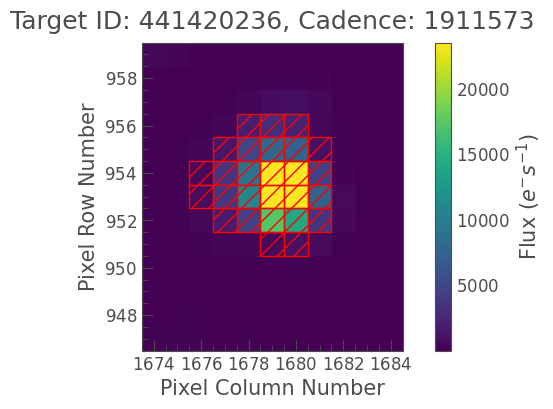

In [10]:
tpf = tpf_search_result[4].download()
tpf.plot(aperture_mask='pipeline')

You can also take the TPF and pipeline aperture to create a lightcurve. The [to_lightcurve](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.KeplerTargetPixelFile.to_lightcurve.html) function will return a Lightkurve [TessLightCurve](https://lightkurve.github.io/lightkurve/reference/lightcurve.html) product. We will talk more about how to use lightcurves in section 2 below. 

In [11]:
tpf.to_lightcurve(aperture_mask='pipeline')

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,pix,pix,,
Time,float32,float32,float64,float64,int32,int32
3882.423449589154,272967.03125,65.3277359008789,1679.3176129896747,953.3704338592537,1911573,4096
3882.4248384866924,273008.875,64.98712158203125,1679.3201313832792,953.3613059728649,1911574,4096
3882.426227384696,273099.0,64.66305541992188,1679.318060002385,953.3699662857368,1911575,4096
3882.427616282234,273000.84375,64.34651184082031,1679.3244210710805,953.3601580900366,1911576,4096
3882.4290051797716,273179.78125,64.05896759033203,1679.3177158977546,953.3676785867402,1911577,4096
3882.43039407731,273082.65625,63.76838684082031,1679.3194879956538,953.3661965057137,1911578,4096
...,...,...,...,...,...,...
3907.53968780508,281633.9375,59.303260803222656,1679.3280258077175,953.1122770990762,1929657,32768


## 1.3 Light Curves

Finally, maybe you aren't interested in the pixel-level detail and you just want to access a lightcurve (time vs flux) for a target. Lightkurve also allows you to search for lightcurves generated by the mission and by the community as High Level Science Products ([HLSPs](https://mast.stsci.edu/hlsp/#/)). 

In [12]:
lc_search_result = lk.search_lightcurve('AU Mic') 
lc_search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,441420236,0.0
1,TESS Sector 27,2020,SPOC,20,441420236,0.0
2,TESS Sector 27,2020,SPOC,120,441420236,0.0
3,TESS Sector 95,2025,SPOC,20,441420236,0.0
4,TESS Sector 95,2025,SPOC,120,441420236,0.0
5,TESS Sector 01,2018,TESS-SPOC,1800,441420236,0.0
6,TESS Sector 27,2020,TESS-SPOC,600,441420236,0.0
7,TESS Sector 01,2018,QLP,1800,441420236,0.0
8,TESS Sector 27,2020,QLP,600,441420236,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

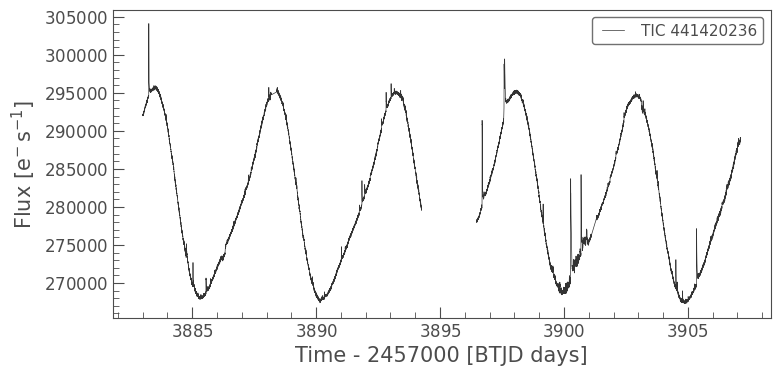

In [13]:
lc = lc_search_result[4].download() # Download the 4th data product, which is the 2-minute cadence lightcurve for sector 95.
lc.plot()

# 2 - Inspecting and Manipulating Data

Great! By one of the methods above, we now have the lightcurve data for AU Mic downloaded and ready to explore. What's the first thing that stands out about this star's lightcurve?

If you said the variability, I'd say I agree with you! The sinusoidal pattern in this lightcurve is caused by stellar activity, specifically when star spots rotate in and out of view. While it looks really cool, it makes studying the flares (and finding the planets) tricky. Lightkurve has built-in functions that can make it easy to detrend the lightcurve, making the features more obvious.

The [flatten](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.flatten.html) function by default uses a [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) with a window length of 101. The lightkurve function wraps the scipy [savgol_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html). You can try out different parameters you find in the documentation to see how it affects the lightcurve. Below, we modify the window length from the default. 


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

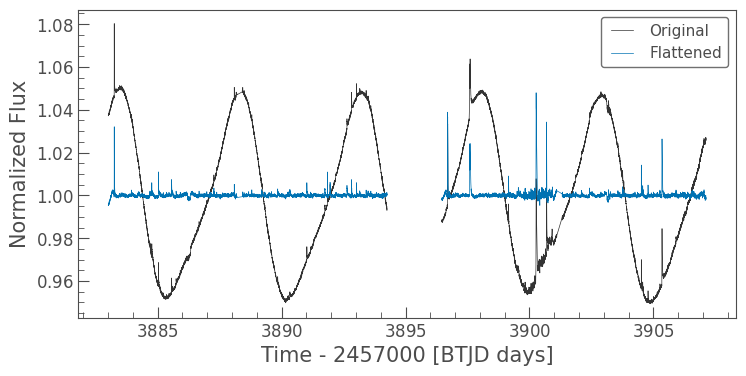

In [14]:
flattened_lc = lc.flatten(window_length=501)

ax = lc.normalize().plot(label='Original')
flattened_lc.plot(ax=ax, label='Flattened')

Let's take a close up look at one of the flares. There are a lot to choose from here! Let
s focus on the large flare that you can see between BJD 3905 and BJD 3906.

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

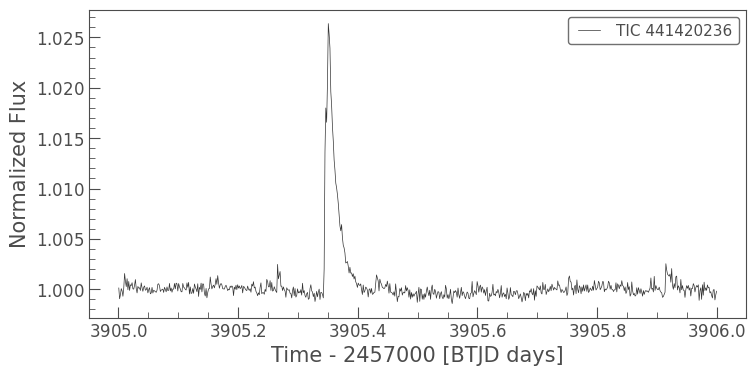

In [15]:
# Note how you can 'slice' the lightcurve using the time column
flattened_lc[(flattened_lc['time'].value > 3905) & (flattened_lc['time'].value < 3906)].plot()

The lightcurve shows the classic fast rise-slow decy profile of a stellar flare. Can you identify another flare in the data?

In addition to the flares, there is also another interesting feature in the data right around BJD 3886. Let's zoom in and check it out. 

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

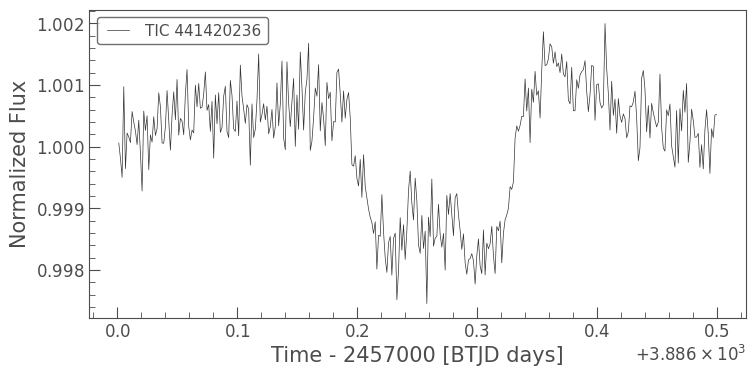

In [16]:
flattened_lc[(flattened_lc['time'].value > 3886) & (flattened_lc['time'].value < 3886.5)].plot()

This looks like the flat-bottomed box shape that is characteristic of a planet. Let's test this and see if it lines up with any of the known planet transits. We will use the lightkurve function [create_transit_mask](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.create_transit_mask.html) to identify figure out the transit times from the literature values

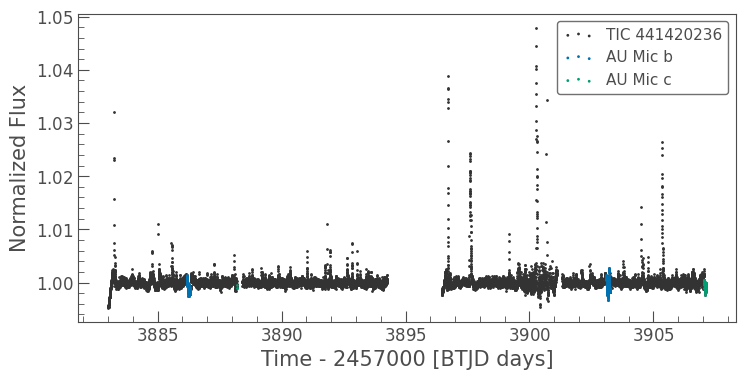

In [17]:
# Make a dictionary of the period (days) time (JD), duration (hrs) for Au Mic b and c. Note these are values from the literature. 
planets = {'b': [8.46308, 2458525.04109, 3.4927], 
           'c': [18.85969, 2458342.2240, 4.236]}

ax = flattened_lc.scatter() # plot the data
for planet, value in planets.items():
    mask = flattened_lc.create_transit_mask(period = value[0], transit_time = value[1] - 2457000, duration=value[2]/24) # mask out the transit
    flattened_lc[mask].scatter(ax=ax, label=f"AU Mic {planet}") #overplot only the predicted in transit data

Looks like that dip corresponds to the transit time of AU Mic b! You can see that there is also another transit of planet b later in the lightcurve. Let's [fold](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.fold.html) the data on the transit period and see if we get a better tranist. 

(0.99, 1.01)

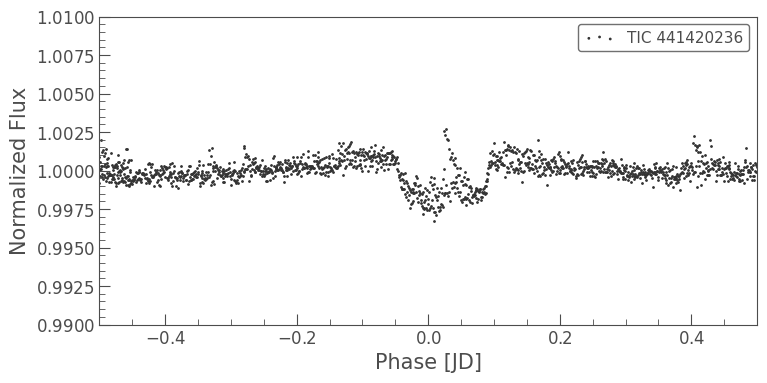

In [18]:
ax = flattened_lc.fold(period=planets['b'][0], epoch_time=planets['b'][1]-2457000).scatter()
ax.set_xlim(-.5, .5) # Plot half a day before the transit to have a day after
ax.set_ylim(.99, 1.01)

The transit shape looks similar, but there may be a flare during the second transit event. As an exercise for the user, check to see whether this feature is from a flare or an artifact of the flattening we did on this lightcurve. 

What if we don't care about exoplanet transits (gasp!!) but we do care about stellar activity. Can we find the rotation period of AU Mic? Lightkurve allows you to run a [periodogram](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.to_periodogram.html) on your data to try to find the period. Let's try it with the original (no flattened) lightcurve. For this purpose we will use the Lomb Scargle Periodogram, although lightkurve does have a built in Box Least Squares periodogram opiton for searching for planet transit signals (ew, those again?). Note we are going back to the original lightcurve, NOT the flattened lightcurve as the signal we want was effectively removed in the flattening process.

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

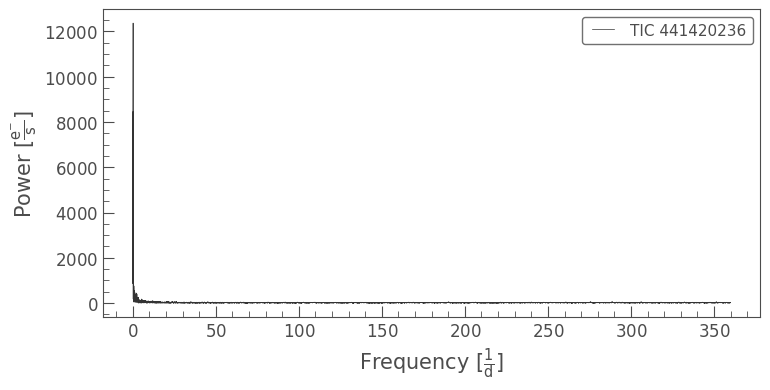

In [19]:
pdgrm = lc.to_periodogram()
pdgrm.plot()

In [20]:
pdgrm.period_at_max_power

<Quantity 4.8246389 d>

<Axes: xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

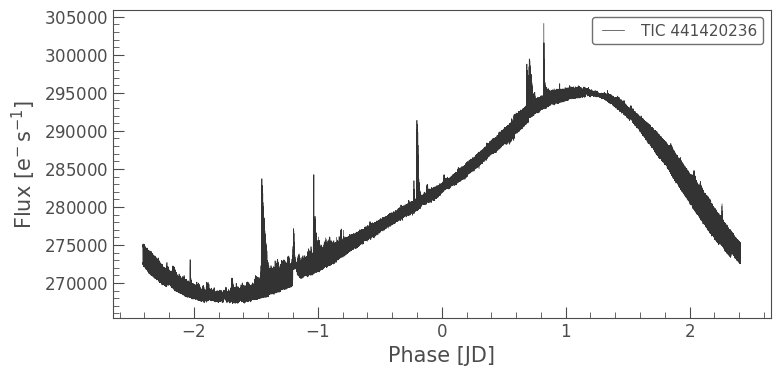

In [21]:
lc.fold(period=pdgrm.period_at_max_power).plot()

The period of 4.82 days closely matches the [literature rotation period values](https://exoplanetarchive.ipac.caltech.edu/overview/AU%20Mic%20b#planet_AU-Mic-b_collapsible).

# Conclusion

As you can see, there are a lot of useful functions built in to lightkurve to make accesssing and exploring TESS data easy. There is a lot more you can do with lightkurve that we didn't have time to cover here. You can check out the [tutorials](https://lightkurve.github.io/lightkurve/tutorials/index.html) for more examples, as well as science cases in other fields including asteroseismology and supernova science. 